<a href="https://colab.research.google.com/github/tupoylogin/CVPR_Lab_2/blob/master/Descriptors%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.15.0
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 1.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 1.7MB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
import sklearn
import cv2
import pandas as pd
import numpy as np

In [0]:
descriptors={'surf': cv2.xfeatures2d.SURF_create().detect,
             'sift': cv2.xfeatures2d.SIFT_create().detect,
             'akaze': cv2.AKAZE_create().detect}

In [4]:
! git clone https://github.com/tupoylogin/CVPR_Lab_2.git

Cloning into 'CVPR_Lab_2'...
remote: Enumerating objects: 51937, done.
remote: Total 51937 (delta 0), reused 0 (delta 0), pack-reused 51937
Receiving objects: 100% (51937/51937), 299.48 MiB | 3.36 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (51893/51893), done.


In [0]:
import os

basePath = os.path.join(os.curdir,'CVPR_Lab_2')

def load_split(basePath, csvPath):
    
    from sklearn.utils import shuffle
    
    # initialize the list of data and labels
    data = []
    labels = []
 
    # load the contents of the CSV file, remove the first line (since
    # it contains the CSV header), and shuffle the rows (otherwise
    # all examples of a particular class will be in sequential order)
    
    rows_df = pd.read_csv(csvPath)[['ClassId','Path']]
    
    rows = shuffle(rows_df.values)
    # loop over the rows of the CSV file
    for row in rows:
        # check to see if we should show a status update
        (label, imagePath) = row[0], row[1]
 
        # derive the full path to the image file and load it
        imagePath = os.path.sep.join([basePath, imagePath])
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # resize the image to be 64x64 pixels, ignoring aspect ratio,
        # and then perform Histogram Equalization
        image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
        #image = cv2.equalizeHist(image) 
        # update the list of data and labels, respectively
        data.append(image)
        labels.append(int(label))
 
    # convert the data and labels to NumPy arrays
    data = np.array(data)
    
 
    # return a tuple of the data and labels
    return rows_df, data

In [0]:
train, data = load_split(basePath,os.path.join(basePath, 'Train.csv'))

In [65]:
train

,ClassId,Path
0,20,Train/20/00020_00000_00000.png
1,20,Train/20/00020_00000_00001.png
2,20,Train/20/00020_00000_00002.png
3,20,Train/20/00020_00000_00003.png
4,20,Train/20/00020_00000_00004.png
...,...,...
39204,42,Train/42/00042_00007_00025.png
39205,42,Train/42/00042_00007_00026.png
39206,42,Train/42/00042_00007_00027.png
39207,42,Train/42/00042_00007_00028.png


In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

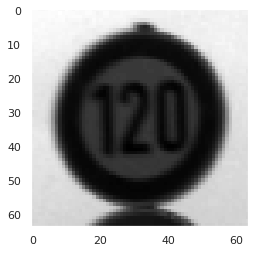

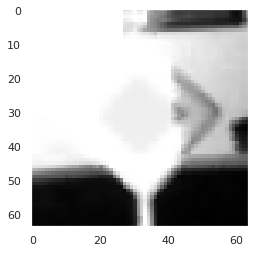

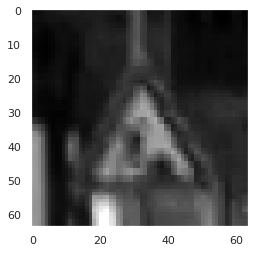

<Figure size 432x288 with 0 Axes>

In [68]:
sns.set()
with sns.axes_style({'axes.grid': False}):
    for idx, image in enumerate(data[:3]): 
        plt.imshow(data[idx],'gray'),plt.show()
        plt.figure(idx+1)

In [0]:
def get_key_pts(algorithm,img,verbose=False):
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kp = algorithm(img,None)
    return np.array([kp[idx].pt for idx in range(0, len(kp))]).flatten()

def to_same_dims(array, dim):
  # kp = np.zeros([len(array),len(max(array,key = lambda x: len(x)))])
  kp = np.zeros([len(array),dim])
  for i,j in enumerate(array):
      if len(j)>dim:
        kp[i][0:dim] = j[0:dim]
      else:
        kp[i][0:len(j)] = j
  return kp

In [0]:
keyp_array_train = []
for img in data:
    kp = get_key_pts(descriptors['sift'], img)
    keyp_array_train.append(kp)

keyp_array_train = to_same_dims(keyp_array_train,256)

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
test, test_data = load_split(basePath,os.path.join(basePath, 'Test.csv'))

keyp_array_test = []
for img in test_data:
    kp = get_key_pts(descriptors['sift'], img)
    keyp_array_test.append(kp)

keyp_array_test = to_same_dims(keyp_array_test,256)

In [0]:
sc = MinMaxScaler()

keyp_array_train = sc.fit_transform(keyp_array_train)
keyp_array_test = sc.transform(keyp_array_test)

In [74]:
import keras
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

batch_size = 32
num_classes = train['ClassId'].unique().shape[0]

# The data, split between train and test sets:
print('x_train shape:', data.shape)
print(data.shape[0], 'train samples')
print(test_data.shape[0], 'test samples')

height, width = data.shape[1:]
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(train['ClassId'].values, num_classes)
y_test = keras.utils.to_categorical(test['ClassId'].values, num_classes)
x_train = data.astype('float32')
x_test = test_data.astype('float32')
x_train /= 255
x_test /= 255
x_train = x_train.reshape((x_train.shape[0], height, width,1))
x_test = x_test.reshape((x_test.shape[0], height, width,1))

classTotals = y_train.sum(axis=0)
classWeight = classTotals.max() / classTotals

def load_model(x_train, x_test, num_classes):

  model = Sequential()
  model.add(Conv2D(16, (5, 5), padding='same', 
                   input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))	

  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(Activation("relu"))
  model.add(Dropout(0.5))

  model.add(Dense(256))
  model.add(Activation("relu"))
  model.add(Dropout(0.5))
 
	# softmax classifier
  model.add(Dense(num_classes))
  model.add(Activation("softmax"))

  # initiate RMSprop optimizer
  opt = Adam(lr=1e-3, decay=1e-3)

  # Let's train the model using RMSprop
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  
  return model

def train_model(model, x_train, y_train, x_test, y_test, epochs,
                class_weights, data_augmentation=True):
  if not data_augmentation:
      print('Not using data augmentation.')
      history = model.fit(x_train, y_train,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_test, y_test),
                shuffle=True)
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          rotation_range=10,
          zoom_range=0.15,
	        width_shift_range=0.1,
	        height_shift_range=0.1,
	        shear_range=0.15,
	        horizontal_flip=False,
	        vertical_flip=False,
	        fill_mode="nearest")

      history = model.fit_generator(datagen.flow(x_train, y_train,
                                      batch_size=batch_size),
                          epochs=epochs, class_weight=class_weights,
                          validation_data=(x_test, y_test),
                          workers=4)
      
      return history

x_train shape: (39209, 64, 64)
39209 train samples
12630 test samples


In [0]:
model = load_model(x_train=x_train, x_test=x_test, num_classes=num_classes)

In [76]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 64, 64, 16)        416       
_________________________________________________________________
activation_76 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_77 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 16, 32)      

In [77]:
history = train_model(model, x_train, y_train, 
                      x_test, y_test, epochs=30, class_weights=classWeight, data_augmentation=True)

Using real-time data augmentation.
Epoch 1/30
1226/1226 [==============================] - 43s 35ms/step - loss: 3.5865 - acc: 0.0522 - val_loss: 3.4933 - val_acc: 0.0583
Epoch 2/30
1226/1226 [==============================] - 40s 32ms/step - loss: 3.5203 - acc: 0.0538 - val_loss: 3.4913 - val_acc: 0.0595
Epoch 3/30
1226/1226 [==============================] - 40s 33ms/step - loss: 3.5078 - acc: 0.0561 - val_loss: 3.4865 - val_acc: 0.0555
Epoch 4/30
1226/1226 [==============================] - 40s 33ms/step - loss: 3.5016 - acc: 0.0561 - val_loss: 3.4734 - val_acc: 0.0581
Epoch 5/30
1226/1226 [==============================] - 40s 33ms/step - loss: 3.4953 - acc: 0.0563 - val_loss: 3.4667 - val_acc: 0.0601
Epoch 6/30
1226/1226 [==============================] - 40s 32ms/step - loss: 3.4918 - acc: 0.0564 - val_loss: 3.4642 - val_acc: 0.0593
Epoch 7/30
1226/1226 [==============================] - 40s 33ms/step - loss: 3.4904 - acc: 0.0556 - val_loss: 3.4637 - val_acc: 0.0587
Epoch 8/30
12

In [69]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

(64, 64)

array([[[[0.8862745 ],
         [0.8862745 ],
         [0.8980392 ],
         ...,
         [0.42352942],
         [0.44705883],
         [0.4509804 ]],

        [[0.8862745 ],
         [0.8901961 ],
         [0.90588236],
         ...,
         [0.4       ],
         [0.41960785],
         [0.42352942]],

        [[0.8980392 ],
         [0.90588236],
         [0.92156863],
         ...,
         [0.33333334],
         [0.34901962],
         [0.35686275]],

        ...,

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.13333334],
         [0.11372549],
         [0.11372549]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.14901961],
         [0.11372549],
         [0.11372549]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.14901961],
         [0.13333334],
         [0.11372549]]],


       [[[0.47843137],
         [0.47843137],
         [0.42